### Building Blocks

In this notebook we focus on the growth trend component of Prophet. Specifically, we focus on its design and implementation in PyMC3.

Acknowledgement: https://www.ritchievink.com/blog/2018/10/09/build-facebooks-prophet-in-pymc3-bayesian-time-series-analyis-with-generalized-additive-models/

In [1]:
import numpy as np
import pymc3 as pm
import matplotlib.pyplot as plt
from scipy import stats
import pandas as pd
import theano
import theano.tensor as tt
from fbprophet import Prophet

np.random.seed(25)
n_changepoints = 10
t = np.arange(1000)

s = np.sort(np.random.choice(t, n_changepoints, replace=False))

A = (t.reshape(-1, 1) > s)*1
delta = np.random.normal(size=n_changepoints)

#### Composition of the Growth Component

The growth component used in FB-Prophet is rather unintuitive at first look. Below I try to breakdown the two components involved to understand how and why the formula used works.

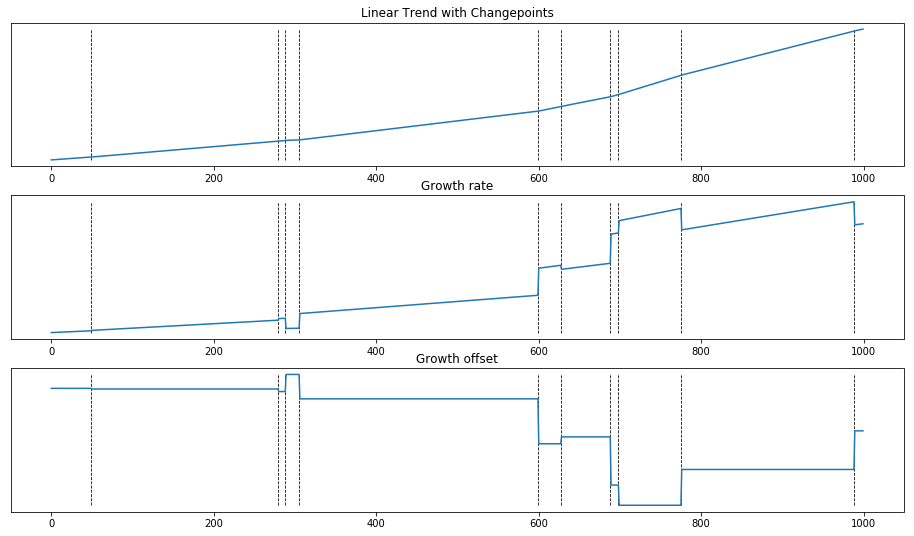

In [2]:
# hand-picked values for sake of example
k=1
m=5

plt.figure(figsize=(16, 3 * 3))
n = 310
i = 0

# @: simple matrix multiplication
# *: element-wise multiplication of matrices
growth = (k + A @ delta) * t
gamma = -s * delta
offset = m + A @ gamma

trend = growth + offset

label_tuple = zip(['Linear Trend with Changepoints', 
                   'Growth rate', 
                   'Growth offset'
                  ],
                [trend, growth, offset]
            )

for t, f in label_tuple:
    i += 1
    plt.subplot(n + i)
    plt.title(t)
    plt.yticks([])
    plt.vlines(s, min(f), max(f), lw=0.8, linestyles='--')
    plt.plot(f)

plt.show()

#### Concrete Example

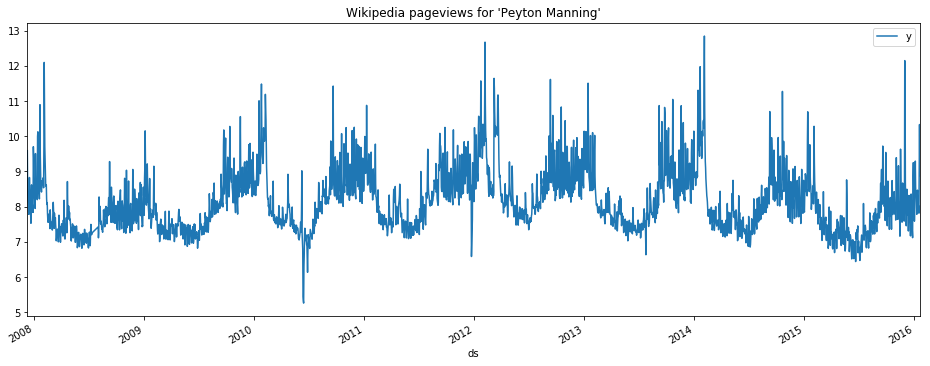

In [3]:
df = pd.read_csv('peyton_manning.csv')
# Make sure we work with datetime types
df['ds'] = pd.to_datetime(df['ds'])
# Scale the data
df['y_scaled'] = df['y'] / df['y'].max()
df['t'] = (df['ds'] - df['ds'].min()) / (df['ds'].max() - df['ds'].min())
df.plot(x='ds', y='y', figsize=(16, 6), title="Wikipedia pageviews for 'Peyton Manning'")

#### Model Definition in PyMC3

In [4]:
def growth_model(model,
                 scaled_time,
                 n_changepoints=125,
                 growth_prior_scale=5,
                 changepoints_prior_scale=0.25,
                 changepoint_range=0.8
                ):
    
    # changepoints spread uniformly between 0 and 0.8 of history
    s = np.linspace(0, changepoint_range*np.max(scaled_time), n_changepoints+1)[1:]
    A = (scaled_time.reshape(-1, 1) > s)*1
    
    with model:
        k = pm.Normal('k', mu=0, sd=growth_prior_scale)
        delta = pm.Laplace('delta', 0, changepoints_prior_scale, shape=n_changepoints)
        m = pm.Normal('m', mu=0, sd=5)
        gamma = -s * delta

        growth_func = (k + tt.dot(A, delta)) * scaled_time + (m + tt.dot(A, gamma))
        
    return growth_func, A, s

with pm.Model() as model:
    y, A, s = growth_model(model, df['t'].values)
    
    sigma = pm.HalfCauchy('sigma', 0.5, testval=1)
    y_obs = pm.Normal('y_obs', mu=y, sd=sigma, observed=df['y_scaled'])
    # trace = pm.sample(init='adapt_diag')

#### Result by using MCMC sampling

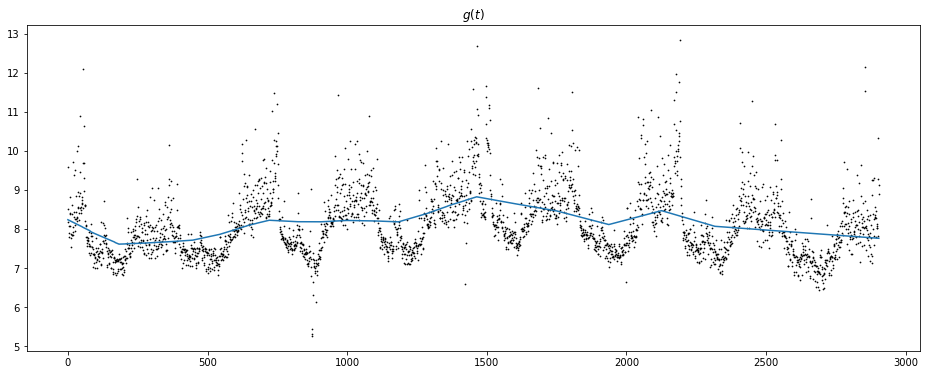

In [175]:
mean_delta = trace['delta'].mean(axis=0)
mean_sigma = trace['sigma'].mean()
mean_m = trace['m'].mean()
mean_k = trace['k'].mean()

def det_trend(k, m, delta, t, s, A):
    return (k + np.dot(A, delta)) * t + (m + np.dot(A, (-s * delta)))

g = det_trend(mean_k, mean_m, mean_delta, df['t'], s, A) * df['y'].max()

plt.figure(figsize=(16, 6))
plt.title('$g(t)$')
plt.plot(g)
plt.scatter(np.arange(df.shape[0]), df.y, s=0.5, color='black')
plt.show()

#### Result by using MAP estimate

/Users/paresh/anaconda3/lib/python3.6/site-packages/pymc3/tuning/starting.py:61: UserWarning: find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
  warnings.warn('find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.')
logp = 4,523.4, ||grad|| = 85.098: 100%|██████████| 1292/1292 [00:03<00:00, 367.63it/s]


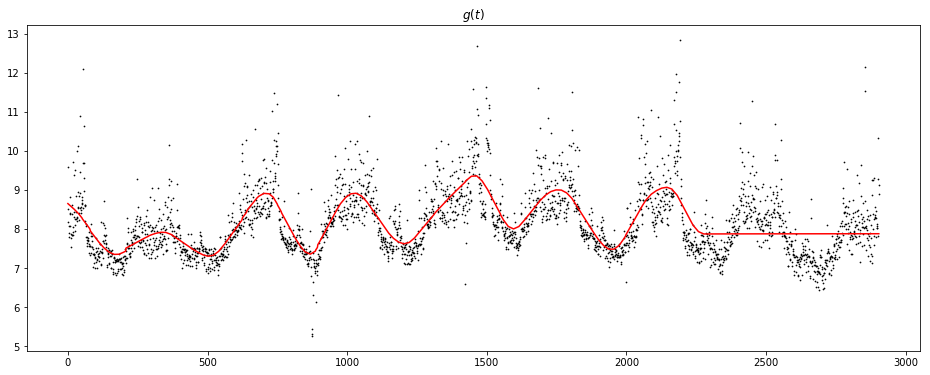

In [7]:
def det_trend(k, m, delta, t, s, A):
    return (k + np.dot(A, delta)) * t + (m + np.dot(A, (-s * delta)))

map_trace = pm.find_MAP(model=model)

g_map = det_trend(map_trace['k'], map_trace['m'], map_trace['delta'], df['t'], s, A) * df['y'].max()

plt.figure(figsize=(16, 6))
plt.title('$g(t)$')
plt.plot(g_map, 'r')
# plt.plot(g, 'b')
plt.scatter(np.arange(df.shape[0]), df.y, s=0.5, color='black')
plt.show()

 1. Regularization: [Automatic Changepoint Detection in Prophet](https://facebook.github.io/prophet/docs/trend_changepoints.html)
 
 2. Accounting for Control Variables: For a typical use-case of Prophet it is implicitly assumed that the observations in our data are independent of any control variables. What about cases where this is not true? (We are using Xgboost on the residuals for Ski data)
 
 3. Variational Inference?

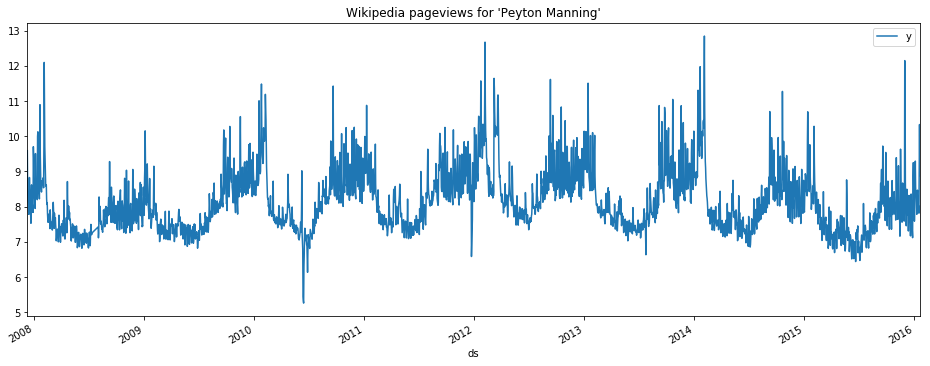

In [16]:
df = pd.read_csv('peyton_manning.csv')
# Make sure we work with datetime types
df['ds'] = pd.to_datetime(df['ds'])
# Scale the data
df['y_scaled'] = df['y'] / df['y'].max()
df['t'] = (df['ds'] - df['ds'].min()) / (df['ds'].max() - df['ds'].min())
df.plot(x='ds', y='y', figsize=(16, 6), title="Wikipedia pageviews for 'Peyton Manning'")
# =============

In [30]:
def growth_model(model,
                 scaled_time,
                 n_changepoints=125,
                 growth_prior_scale=5,
                 changepoints_prior_scale=0.05,
                 changepoint_range=0.8
                ):
    
    # changepoints spread uniformly between 0 and 0.8 of history
    s = np.linspace(0, changepoint_range*np.max(scaled_time), n_changepoints+1)[1:]
    A = (scaled_time.reshape(-1, 1) > s)*1
    
    with model:
        k = pm.Normal('k', mu=0, sd=growth_prior_scale)
        delta = pm.Laplace('delta', 0, changepoints_prior_scale, shape=n_changepoints)
        m = pm.Normal('m', mu=0, sd=5)
        gamma = -s * delta

        growth_func = (k + tt.dot(A, delta)) * scaled_time + (m + tt.dot(A, gamma))
        
    return growth_func, A, s

def seasonality_model(model, 
                      t, 
                      order=10, 
                      period=365.25,
                      seasonality_prior_scale=10
                     ):
    # IMP: We are working in normalized time.
    period = period / (df['ds'].max() - df['ds'].min()).days
    tmp = (2 * np.pi/period) * np.arange(1, order+1)
    tmp = tmp * t[:, None]
    tmp = np.concatenate((np.cos(tmp), np.sin(tmp)), axis=1)
    
    with model:
        beta = pm.Normal('beta', 0, seasonality_prior_scale, shape=2*order)
        year_season = tt.dot(tmp, beta)
        
    return tmp, year_season 

with pm.Model() as model:
    y_growth, A, s = growth_model(model, df['t'].values)
    base, y_yearly = seasonality_model(model, df['t'].values)
    
    y = y_growth + y_yearly 
    sigma = pm.HalfCauchy('sigma', 0.5, testval=1)
    y_obs = pm.Normal('y_obs', mu=y, sd=sigma, observed=df['y_scaled'])
    # trace = pm.sample(init='adapt_diag')

/Users/paresh/anaconda3/lib/python3.6/site-packages/pymc3/tuning/starting.py:61: UserWarning: find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
  warnings.warn('find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.')
logp = 5,348.3, ||grad|| = 211.06: 100%|██████████| 843/843 [00:02<00:00, 317.62it/s] 


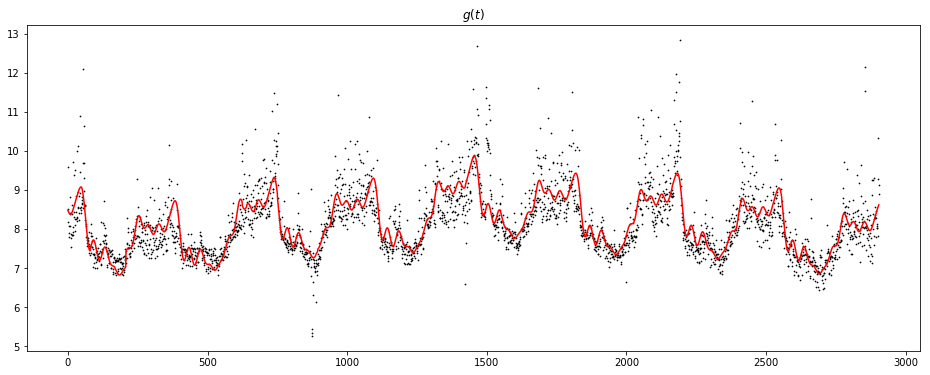

In [33]:
def det_trend(k, m, delta, t, s, A):
    return (k + np.dot(A, delta)) * t + (m + np.dot(A, (-s * delta)))

def det_season(base, beta):
    return base @ beta
    
map_trace = pm.find_MAP(model=model)

growth_map = det_trend(map_trace['k'], map_trace['m'], map_trace['delta'], df['t'], s, A) * df['y'].max()
season_map = det_season(base, map_trace['beta']) * df['y'].max()

plt.figure(figsize=(16, 6))
plt.title('$g(t)$')
plt.plot(growth_map+season_map, 'r')
# plt.plot(g, 'b')
plt.scatter(np.arange(df.shape[0]), df.y, s=0.5, color='black')
plt.show()